## 1. Импорт данных и библиотек

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Загрузка данных
file_path = 'rub_data.xlsx'
data = pd.read_excel(file_path)
data['data'] = pd.to_datetime(data['data'], format='%d.%m.%Y')
data.set_index('data', inplace=True)
data['curs'] = data['curs'].astype(str).str.replace(',', '.').astype(float)
series = data['curs']

C:\Users\catne\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 2. Декомпозиция временного ряда

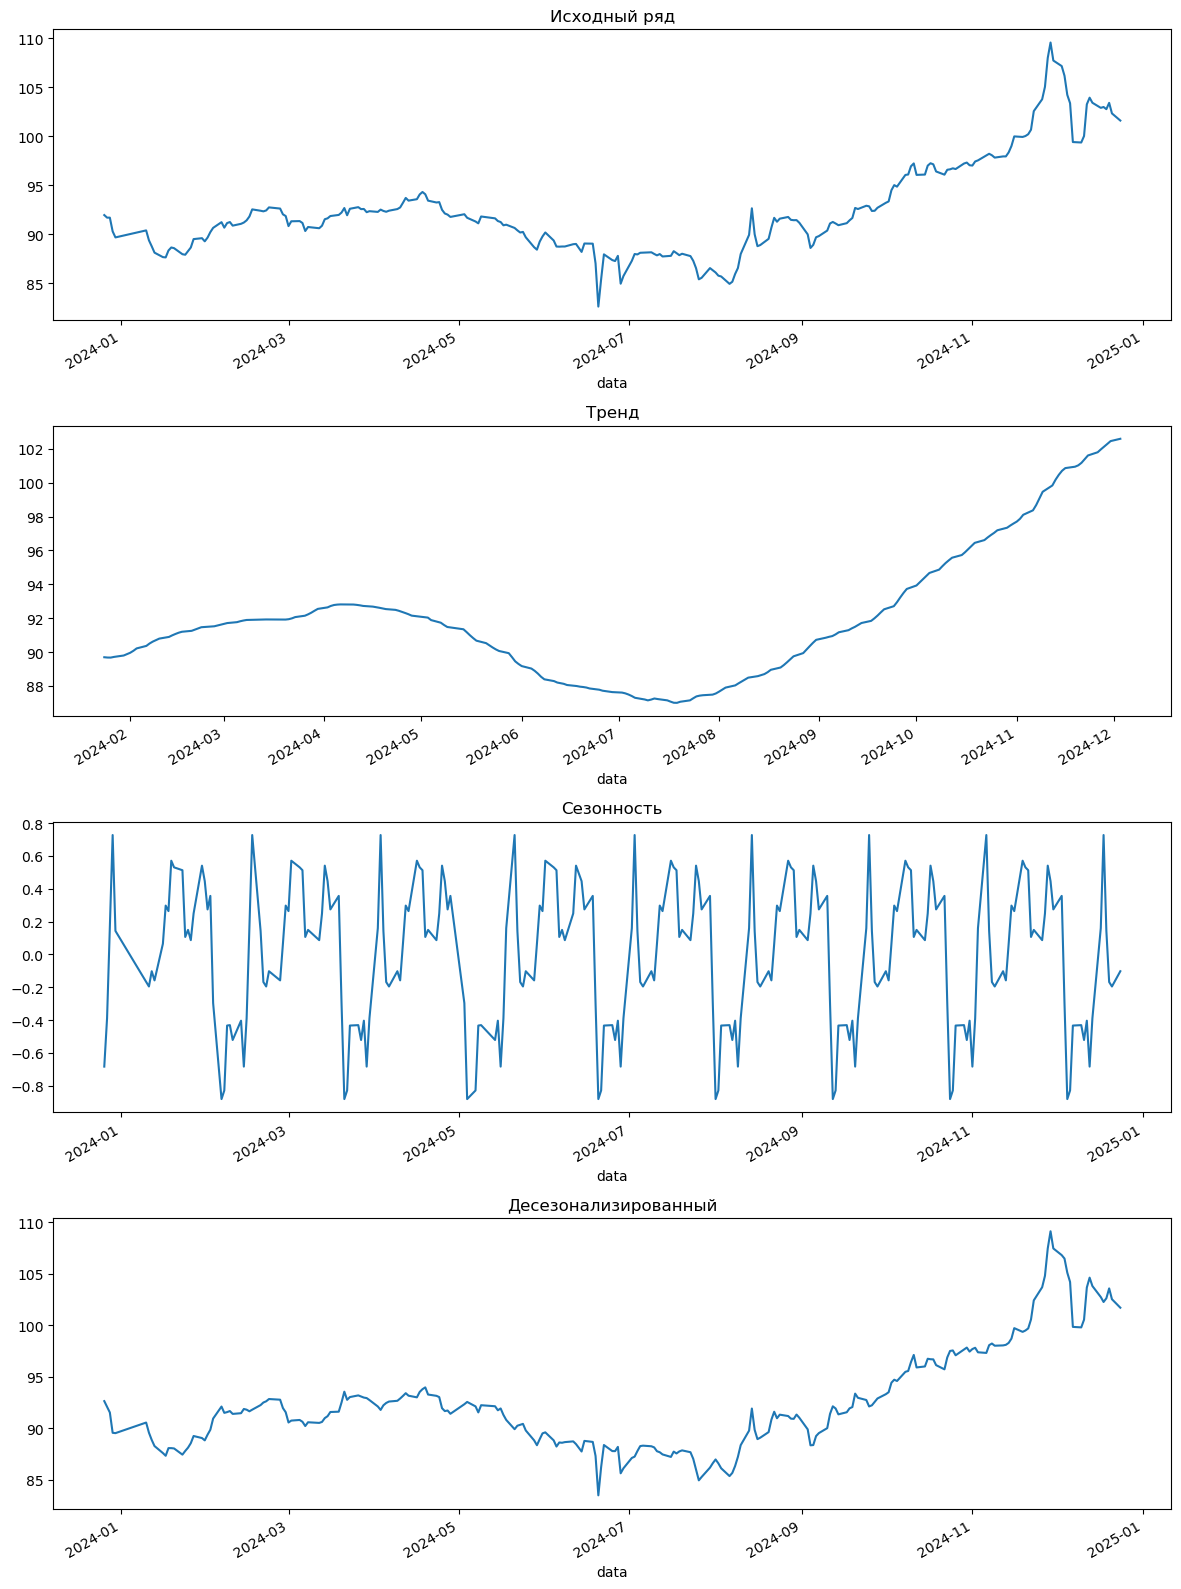

In [94]:
# Декомпозиция
decomposition = seasonal_decompose(series, model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Исходный ряд')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')

deseasonal = decomposition.observed-decomposition.seasonal
deseasonal.plot(ax=ax4)
ax4.set_title('Десезонализированный')

plt.tight_layout()
plt.show()

## 3. Десезонирование ряда

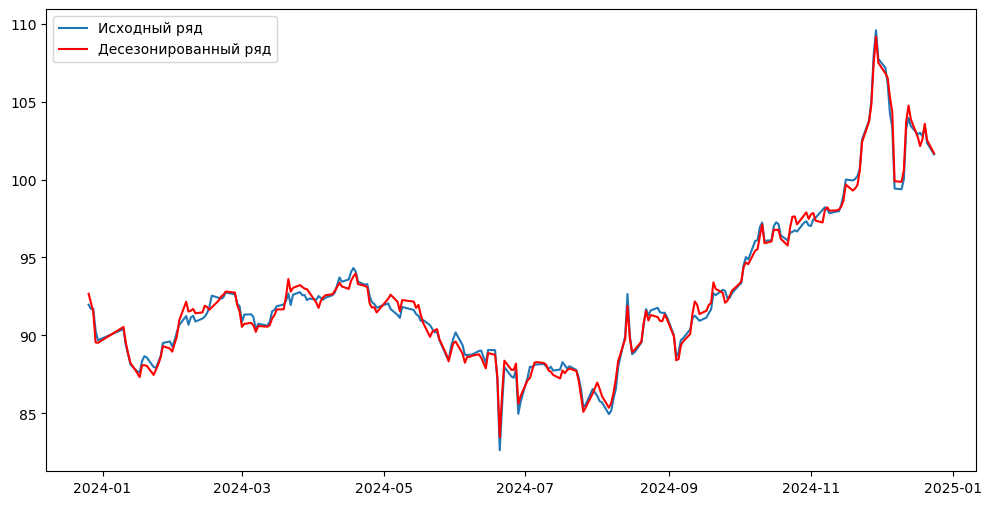

In [95]:
result = seasonal_decompose(series, model='multiplicative', period=30)
deseasonalized_series = series / result.seasonal

plt.figure(figsize=(12, 6))
plt.plot(series, label='Исходный ряд')
plt.plot(deseasonalized_series, label='Десезонированный ряд', color='red')
plt.legend()
plt.show()


## 4. Прогноз на основе тренда и сезонности

C:\Users\catne\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\catne\AppData\Local\Temp\ipykernel_21148\1337142112.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  currency_series = currency_data['curs'].resample('D').last().fillna(method='ffill')


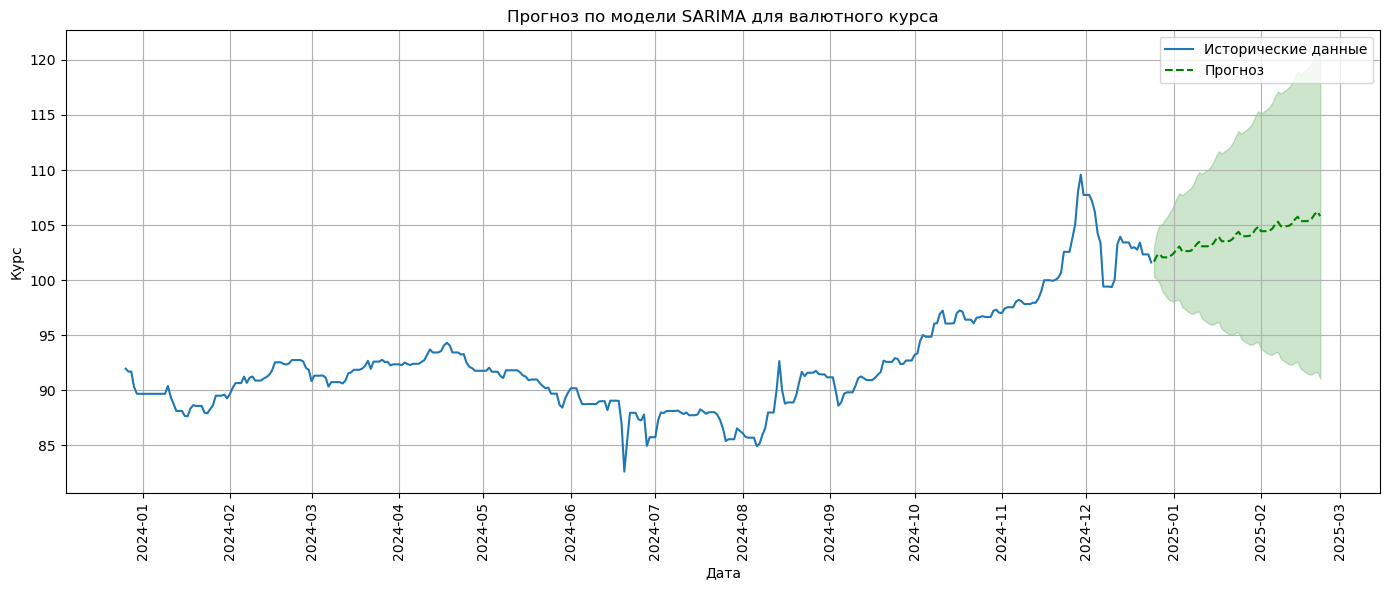

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Загрузка данных из Excel
file_path = 'rub_data.xlsx'
currency_data = pd.read_excel(file_path)
currency_data['data'] = pd.to_datetime(currency_data['data'], format='%d.%m.%Y')
currency_data.set_index('data', inplace=True)

# Преобразование столбца с курсом в числовой формат
currency_data['curs'] = currency_data['curs'].astype(str).str.replace(',', '.').astype(float)

# Данные для анализа
currency_series = currency_data['curs'].resample('D').last().fillna(method='ffill')

# Определим параметры модели SARIMA
model = SARIMAX(currency_series, order=(1,1,1), seasonal_order=(1,1,1,7))

# Обучаем модель
results = model.fit()

# Прогноз на 60 дней вперед
forecast = results.get_forecast(steps=60)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()  # Доверительные интервалы

# Визуализация
plt.figure(figsize=(14, 6))
plt.plot(currency_series.index, currency_series.values, label='Исторические данные')
plt.plot(forecast_mean.index, forecast_mean.values, label='Прогноз', color='green', linestyle='--')
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel("Дата")
plt.ylabel("Курс")
plt.title("Прогноз по модели SARIMA для валютного курса")
plt.legend()
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.grid()
plt.show()

## 5. Тест на стационарность

ADF Statistic: -0.8633774834620266
p-value: 0.7997934500849644
Ряд нестационарен, применено дифференцирование


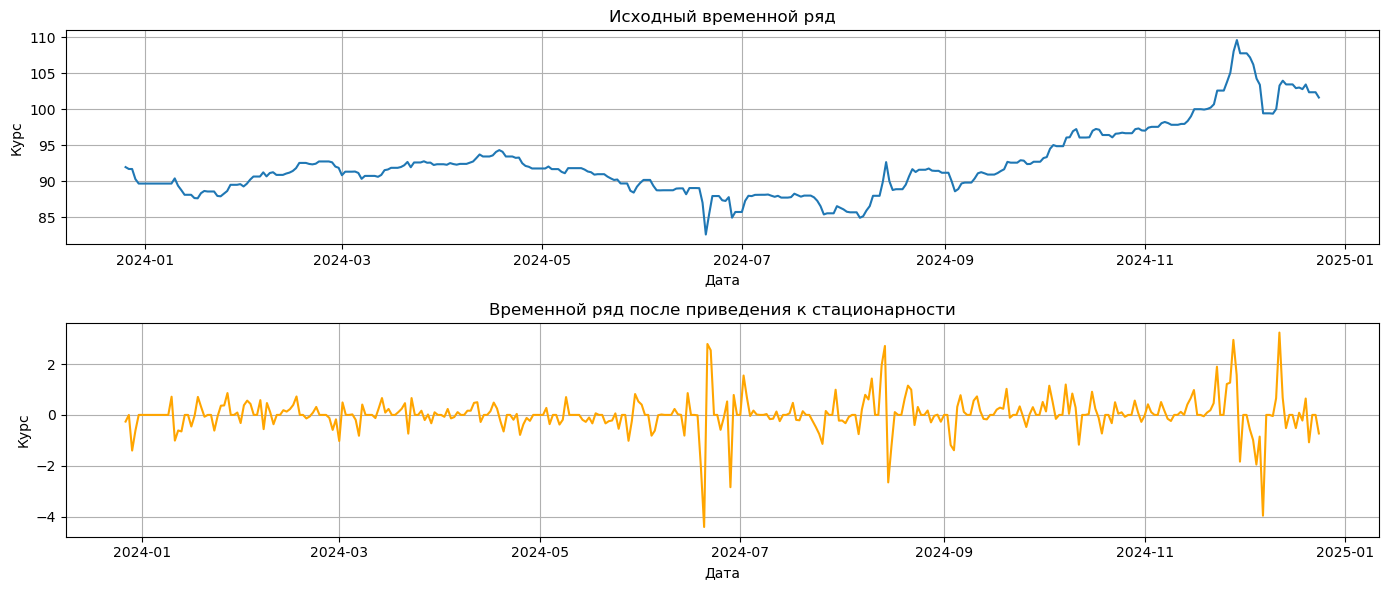

In [10]:

# Выполнение теста на стационарность (ADF)
result = adfuller(currency_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Проверка на стационарность
if result[1] > 0.05:
    stationary_series = currency_series.diff().dropna()
    print("Ряд нестационарен, применено дифференцирование")
else:
    stationary_series = currency_series
    print("Ряд стационарен")

# Визуализация исходного ряда и приведенного к стационарности
plt.figure(figsize=(14, 6))

# График исходного ряда
plt.subplot(2, 1, 1)
plt.plot(currency_series.index, currency_series.values, label='Исходный ряд')
plt.title('Исходный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.grid()

# График стационарного ряда
plt.subplot(2, 1, 2)
plt.plot(stationary_series.index, stationary_series.values, label='Приведенный к стационарности ряд', color='orange')
plt.title('Временной ряд после приведения к стационарности')
plt.xlabel('Дата')
plt.ylabel('Курс')
plt.grid()

plt.tight_layout()
plt.show()

## 6. Построение моделей AR, MA, ARMA и ARIMA

In [27]:

# Функция для оценки модели ARIMA
def evaluate_arima_model(X, arima_order):
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    
    # Обучение модели
    model = ARIMA(train, order=arima_order, trend='ct')
    model_fit = model.fit()
    
    # Прогноз
    forecast = model_fit.forecast(steps=len(test))
    
    # Оценка качества прогноза
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    return mae, rmse

# Настройка диапазонов параметров для AR, MA, ARMA и ARIMA
p_values = range(0, 10)
d_values = [0]
q_values = [0]
deseasonal=stationary_series
# Разделение индексов для deseasonal (обработайте ваш временной ряд)
deseasonal.index = pd.date_range(start=deseasonal.index[0], periods=len(deseasonal), freq=deseasonal.index.inferred_freq)

# Поиск лучших параметров для AR модели

In [28]:
best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')

AR(0, 0, 0) MAE=0.521 RMSE=0.915
AR(1, 0, 0) MAE=0.520 RMSE=0.915
AR(2, 0, 0) MAE=0.528 RMSE=0.917
AR(3, 0, 0) MAE=0.528 RMSE=0.917
AR(4, 0, 0) MAE=0.522 RMSE=0.915
AR(5, 0, 0) MAE=0.522 RMSE=0.915


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR(6, 0, 0) MAE=0.522 RMSE=0.915


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR(7, 0, 0) MAE=0.525 RMSE=0.917
AR(8, 0, 0) MAE=0.526 RMSE=0.917
AR(9, 0, 0) MAE=0.528 RMSE=0.918
Лучшая модель AR(1, 0, 0) MAE=0.520


# Поиск лучших параметров для MA модели

In [26]:
p_values = [0]
q_values = range(0, 10)

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')



MA(0, 0, 0) MAE=0.521 RMSE=0.915
MA(0, 0, 1) MAE=0.520 RMSE=0.915
MA(0, 0, 2) MAE=0.524 RMSE=0.916
MA(0, 0, 3) MAE=0.526 RMSE=0.916
MA(0, 0, 4) MAE=0.524 RMSE=0.916


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MA(0, 0, 5) MAE=0.524 RMSE=0.916


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MA(0, 0, 6) MAE=0.523 RMSE=0.915
MA(0, 0, 7) MAE=0.527 RMSE=0.916
MA(0, 0, 8) MAE=0.527 RMSE=0.915
MA(0, 0, 9) MAE=0.526 RMSE=0.916
Лучшая модель MA(0, 0, 1) MAE=0.520


# Поиск лучших параметров для ARMA модели

In [25]:
p_values = range(0, 5)
q_values = range(0, 5)

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')


ARMA(0, 0, 0) MAE=0.521 RMSE=0.915
ARMA(0, 0, 1) MAE=0.520 RMSE=0.915
ARMA(0, 0, 2) MAE=0.524 RMSE=0.916
ARMA(0, 0, 3) MAE=0.526 RMSE=0.916
ARMA(0, 0, 4) MAE=0.524 RMSE=0.916
ARMA(1, 0, 0) MAE=0.520 RMSE=0.915
ARMA(1, 0, 1) MAE=0.521 RMSE=0.915
ARMA(1, 0, 2) MAE=0.526 RMSE=0.916
ARMA(1, 0, 3) MAE=0.524 RMSE=0.916
ARMA(1, 0, 4) MAE=0.524 RMSE=0.916
ARMA(2, 0, 0) MAE=0.528 RMSE=0.917
ARMA(2, 0, 1) MAE=0.527 RMSE=0.917
ARMA(2, 0, 2) MAE=0.523 RMSE=0.916
ARMA(2, 0, 3) MAE=0.524 RMSE=0.916


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2, 0, 4) MAE=0.524 RMSE=0.916
ARMA(3, 0, 0) MAE=0.528 RMSE=0.917
ARMA(3, 0, 1) MAE=0.527 RMSE=0.917
ARMA(3, 0, 2) MAE=0.523 RMSE=0.915


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 0, 3) MAE=0.523 RMSE=0.916
ARMA(3, 0, 4) MAE=0.524 RMSE=0.916
ARMA(4, 0, 0) MAE=0.522 RMSE=0.915


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(4, 0, 1) MAE=0.522 RMSE=0.915


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4, 0, 2) MAE=0.523 RMSE=0.915
ARMA(4, 0, 3) MAE=0.521 RMSE=0.914
ARMA(4, 0, 4) MAE=0.523 RMSE=0.915
Лучшая модель ARMA(0, 0, 1) MAE=0.520


C:\Users\catne\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Поиск лучших параметров для ARIMA модели

In [23]:

p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

best_score_arima, best_cfg_arima = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=0.521 RMSE=0.915
ARIMA(0, 0, 1) MAE=0.520 RMSE=0.915
ARIMA(0, 0, 2) MAE=0.524 RMSE=0.916
ARIMA(1, 0, 0) MAE=0.520 RMSE=0.915
ARIMA(1, 0, 1) MAE=0.521 RMSE=0.915
ARIMA(1, 0, 2) MAE=0.526 RMSE=0.916
ARIMA(2, 0, 0) MAE=0.528 RMSE=0.917
ARIMA(2, 0, 1) MAE=0.527 RMSE=0.917
ARIMA(2, 0, 2) MAE=0.523 RMSE=0.916
Лучшая модель ARIMA(0, 0, 1) MAE=0.520


## 7. Визуализация результатов

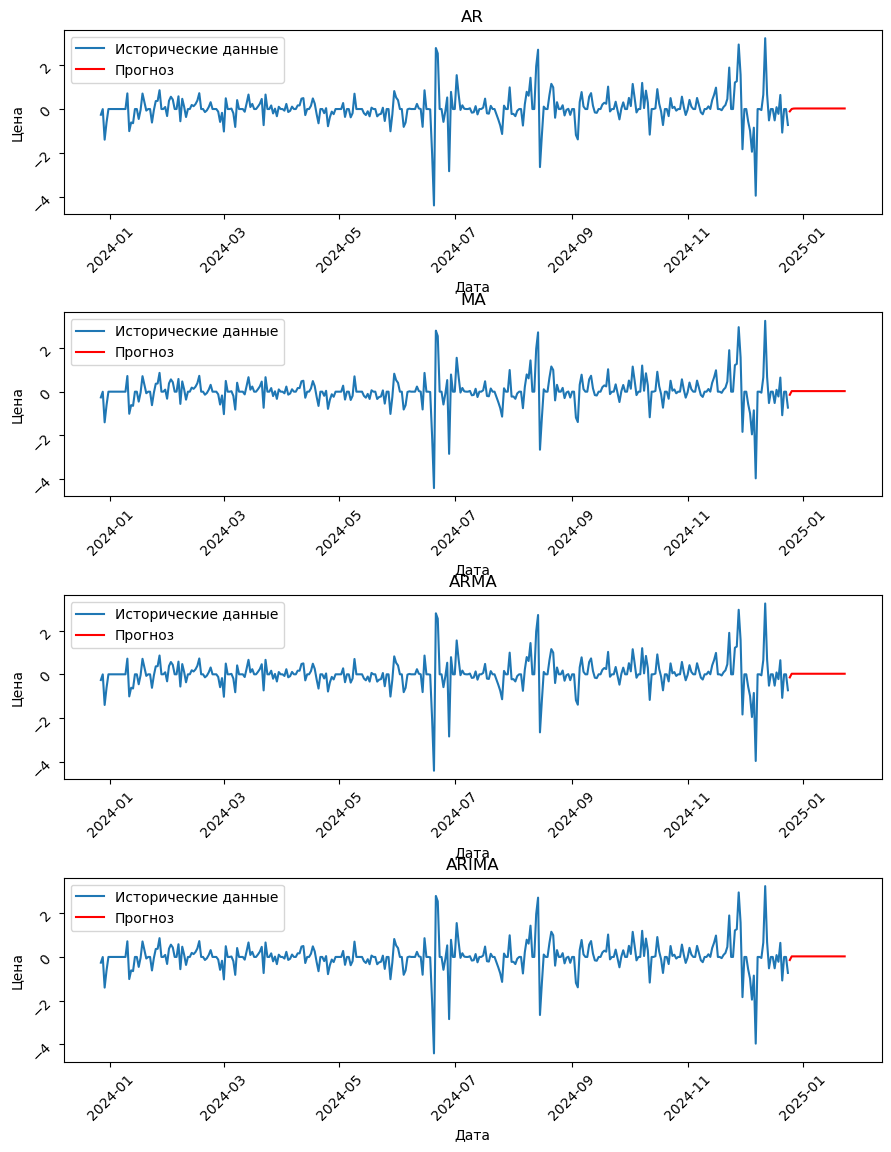

In [21]:

# Обучение моделей с оптимальными параметрами
model_ar = ARIMA(deseasonal, order=best_cfg_ar)
model_ma = ARIMA(deseasonal, order=best_cfg_ma)
model_arma = ARIMA(deseasonal, order=best_cfg_arma)
model_arima = ARIMA(deseasonal, order=best_cfg_arima)

model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()

# Прогнозирование на 30 шагов вперед
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

# Построение графиков
fig, ax = plt.subplots(4, 1, figsize=(10, 12))
fig.tight_layout(pad=5.0)

# AR
ax[0].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[0].plot(forecast_ar.index, forecast_ar, color='red', label='Прогноз')
ax[0].set_title("AR")
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Цена')
ax[0].legend()
ax[0].tick_params(labelrotation=45)

# MA
ax[1].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[1].plot(forecast_ma.index, forecast_ma, color='red', label='Прогноз')
ax[1].set_title("MA")
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Цена')
ax[1].legend()
ax[1].tick_params(labelrotation=45)

# ARMA
ax[2].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[2].plot(forecast_arma.index, forecast_arma, color='red', label='Прогноз')
ax[2].set_title("ARMA")
ax[2].set_xlabel('Дата')
ax[2].set_ylabel('Цена')
ax[2].legend()
ax[2].tick_params(labelrotation=45)

# ARIMA
ax[3].plot(deseasonal.index, deseasonal, label='Исторические данные')
ax[3].plot(forecast_arima.index, forecast_arima, color='red', label='Прогноз')
ax[3].set_title("ARIMA")
ax[3].set_xlabel('Дата')
ax[3].set_ylabel('Цена')
ax[3].legend()
ax[3].tick_params(labelrotation=45)

plt.show()


## Выводы
1. Сезонность оказывает значительное влияние на временной ряд.
2. Удаление сезонности улучшает предсказуемость ряда.
3. Модель ARIMA с оптимальными параметрами показала наилучшие результаты прогноза.